In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
import torch
import torch.nn as nn
import re
from utils_notebook import histogram_experiment, dataframe_to_latex

In [2]:
results_path = "../results/grid_search_new_db"
full_results_df = pd.DataFrame()

In [3]:
# For all folder in results_path
for experiment_folder in os.listdir(results_path):
    # Load the data
    # if experiment starts with DDPM skip
    if experiment_folder.startswith("DDPM"):
        continue
    if "exponential" in experiment_folder or "cosine" in experiment_folder:
            continue
    for dataset_folder in os.listdir(os.path.join(results_path, experiment_folder)):
        if "synthetic" not in dataset_folder:
            continue
        try:
            dataset_results = pd.read_csv(Path(results_path, experiment_folder,dataset_folder, "model_metrics.csv"))
        except Exception as e:
            print(f"Error loading {results_path}/{experiment_folder}/{dataset_folder}/model_metrics.csv")
            print(e)
            continue
        
        dataset_results["experiment"] = experiment_folder
        dataset_results["dataset_name"] = "_".join(dataset_folder.split("_"))
        dataset_results['dataset_version'] = dataset_folder.split("_")[-1]
        dataset_results['nb_bins'] = int(re.search(r"bins(\d+)", experiment_folder).group(1))
        dataset_results['T'] = int(re.search(r"T(\d+)", experiment_folder).group(1))
        full_results_df = pd.concat([full_results_df, dataset_results])


In [4]:
full_results_df = full_results_df.drop(columns=["Unnamed: 0", "model_name", "sampling_method"], )
full_results_df.head()

,training_time,inference_time,f1_score,dataset_name,training_method,random_seed,aucroc,experiment,dataset_version,nb_bins,...,grad_ndcg,shap_explanation_accuracy,shap_feature_importance_ndcg,shap_explanation_time,mean_diffusion_accuracy,mean_diffusion_ndcg,mean_diffusion_time,max_diffusion_accuracy,max_diffusion_ndcg,max_diffusion_time
0,545.190490,0.180269,0.394000,A_synthetic_f4_s5000_c2_r0.05_0.05_seed_4,unsupervised,0,0.744031,DTEC_unsupervised_None_s0_T100_bins7,4,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,545.905368,0.195822,0.844000,A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02...,unsupervised,0,0.991350,DTEC_unsupervised_None_s0_T100_bins7,5,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,523.769845,0.239424,0.545455,A_synthetic_f10_s5000_c4_r0.033_0.033_0.033_se...,unsupervised,0,0.886083,DTEC_unsupervised_None_s0_T100_bins7,2,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,461.863078,0.161886,0.674000,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,unsupervised,0,0.872215,DTEC_unsupervised_None_s0_T100_bins7,3,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,520.101181,0.152035,0.556000,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,unsupervised,0,0.862560,DTEC_unsupervised_None_s0_T100_bins7,4,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
METHOD = 'unsupervised'

In [6]:
for name in full_results_df.columns:
    print(name)

training_time
inference_time
f1_score
dataset_name
training_method
random_seed
aucroc
experiment
dataset_version
nb_bins
T
grad_explanation_accuracy
grad_explanation_time
grad_ndcg
shap_explanation_accuracy
shap_feature_importance_ndcg
shap_explanation_time
mean_diffusion_accuracy
mean_diffusion_ndcg
mean_diffusion_time
max_diffusion_accuracy
max_diffusion_ndcg
max_diffusion_time


In [7]:
# Keep only raws where nb_bin is 7 and T is 400
full_results_df = full_results_df[(full_results_df['nb_bins'] == 7) & (full_results_df['T'] == 400)]

In [8]:

# RAtio are stored in the string as r{ratio1}_{ratio2}_..._{ratioN}
ratios = full_results_df['dataset_name'].str.extract(r'r([0-9]*\.?[0-9]+)|_([0-9]*\.?[0-9]+)')
# Remove empty ratio
# Combine the two capture groups and drop NaNs
ratios = ratios.apply(lambda x: x[0] if pd.notnull(x[0]) else x[1], axis=1).astype(float)

# Sum the ratios grouped by the dataset index
full_results_df['anomaly_ratio'] = ratios.groupby(level=0).sum()

In [9]:
full_results_df

,training_time,inference_time,f1_score,dataset_name,training_method,random_seed,aucroc,experiment,dataset_version,nb_bins,...,shap_explanation_accuracy,shap_feature_importance_ndcg,shap_explanation_time,mean_diffusion_accuracy,mean_diffusion_ndcg,mean_diffusion_time,max_diffusion_accuracy,max_diffusion_ndcg,max_diffusion_time,anomaly_ratio
0,1611.943667,0.247217,0.524000,A_synthetic_f4_s5000_c2_r0.05_0.05_seed_4,DSIL,0,0.763793,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,4,7,...,1.140119,0.500000,17.038071,0.639830,0.500000,0.856678,0.500000,1.069372,0.887974,2.6552
0,362.132840,0.042848,0.890000,A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02...,DSIL,0,0.989764,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,5,7,...,0.207270,0.704867,1172.424147,0.121733,0.591281,5.556387,0.546412,0.521197,5.569720,2.6552
0,1619.971799,0.237706,0.658586,A_synthetic_f10_s5000_c4_r0.033_0.033_0.033_se...,DSIL,0,0.890196,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,2,7,...,0.618806,0.598170,556.366699,0.490097,0.588704,2.400957,0.557200,0.932141,2.491667,2.6552
0,1416.673419,0.156039,0.858000,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,0,0.935408,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,3,7,...,0.012881,0.463578,4904.337335,0.014368,0.456705,282.209920,0.455785,0.074996,260.849657,2.6552
0,1411.419703,0.131961,0.856000,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,0,0.934186,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,4,7,...,0.010808,0.466254,4760.184669,0.013449,0.465497,271.036883,0.463323,0.064506,259.874695,2.6552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,543.212217,0.234080,0.692000,A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.0...,unsupervised,0,0.911093,DTEC_unsupervised_None_s0_T400_bins7,3,7,...,0.122405,0.433571,1329.145182,0.087397,0.422548,22.990035,0.396976,0.445666,23.595227,2.6552
0,541.932048,0.235836,0.700000,A_synthetic_f4_s5000_c2_r0.025_0.025_seed_5,unsupervised,0,0.917133,DTEC_unsupervised_None_s0_T400_bins7,5,7,...,0.956618,0.692000,8.117646,0.625305,0.696000,0.556849,0.692000,1.046222,0.557406,2.6552
0,534.906402,0.193315,0.568000,A_synthetic_f50_s5000_c12_r0.01_0.01_0.01_0.01...,unsupervised,0,0.861925,DTEC_unsupervised_None_s0_T400_bins7,3,7,...,0.206656,0.465776,600.188528,0.089287,0.369689,8.757398,0.360882,0.716829,9.348168,2.6552
0,537.859100,0.196894,0.715152,A_synthetic_f10_s5000_c4_r0.033_0.033_0.033_se...,unsupervised,0,0.906662,DTEC_unsupervised_None_s0_T400_bins7,1,7,...,0.480780,0.624163,560.202486,0.572810,0.590644,2.254708,0.560568,0.956561,2.264383,2.6552


In [20]:
# Compute mean and std for each dataset with different version, but same experiment name
temp_df = full_results_df.drop(columns=["dataset_version"])
temp_df['anomaly_ratio']
mean_df = temp_df.groupby(["experiment", "dataset_name", 'training_method']).mean().reset_index()
std_df = temp_df.groupby(["experiment", "dataset_name", "training_method"]).std().reset_index()


In [21]:
mean_df.head()

,experiment,dataset_name,training_method,training_time,inference_time,f1_score,random_seed,aucroc,nb_bins,T,...,shap_explanation_accuracy,shap_feature_importance_ndcg,shap_explanation_time,mean_diffusion_accuracy,mean_diffusion_ndcg,mean_diffusion_time,max_diffusion_accuracy,max_diffusion_ndcg,max_diffusion_time,anomaly_ratio
0,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,1520.205337,0.215042,0.784,0.0,0.887717,7.0,400.0,...,0.033115,0.410042,2383.935717,0.012835,0.379124,189.715840,0.372750,0.062887,197.257150,2.6552
1,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,1483.827389,0.158783,0.768,0.0,0.881031,7.0,400.0,...,0.032814,0.399824,2437.879841,0.013529,0.397580,196.557224,0.393281,0.063156,191.868555,2.6552
2,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,1509.786278,0.148235,0.748,0.0,0.865208,7.0,400.0,...,0.038104,0.385090,2370.298649,0.011188,0.395855,187.021316,0.388024,0.056442,186.037858,2.6552
3,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,1498.324456,0.146505,0.784,0.0,0.899816,7.0,400.0,...,0.035185,0.410307,2399.534253,0.011799,0.388214,204.989085,0.383789,0.056865,197.901408,2.6552
4,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0....,DSIL,1517.527850,0.162052,0.744,0.0,0.881436,7.0,400.0,...,0.013059,0.398042,2364.803127,0.009495,0.355644,163.201307,0.351685,0.026680,204.361125,2.6552


In [22]:
# std_df.head()

In [23]:
print(full_results_df['experiment'].unique())
print(full_results_df['dataset_name'].unique())

['DTEC_DSIL_deterministic_0.5_s0_T400_bins7'
 'DTEC_unsupervised_None_s0_T400_bins7']
['A_synthetic_f4_s5000_c2_r0.05_0.05_seed_4'
 'A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02_0.02_seed_5'
 'A_synthetic_f10_s5000_c4_r0.033_0.033_0.033_seed_2'
 'A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0.02_0.02_seed_3'
 'A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0.02_0.02_seed_4'
 'A_synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0.01_0.01_seed_1'
 'A_synthetic_f10_s5000_c4_r0.0166_0.0166_0.0166_seed_2'
 'A_synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0.01_0.01_seed_0'
 'A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_0.02_seed_0'
 'A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0.02_0.02_seed_2'
 'A_synthetic_f4_s5000_c2_r0.025_0.025_seed_3'
 'A_synthetic_f10_s5000_c4_r0.033_0.033_0.033_seed_5'
 'A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_0.02_seed_4'
 'A_synthetic_f4_s5000_c2_r0.05_0.05_seed_5'
 'A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_0.02_seed_2'
 'A_synthetic_f50_s5000_c12_r0.02_0.02_0.

In [24]:
mean_df.head()

,experiment,dataset_name,training_method,training_time,inference_time,f1_score,random_seed,aucroc,nb_bins,T,...,shap_explanation_accuracy,shap_feature_importance_ndcg,shap_explanation_time,mean_diffusion_accuracy,mean_diffusion_ndcg,mean_diffusion_time,max_diffusion_accuracy,max_diffusion_ndcg,max_diffusion_time,anomaly_ratio
0,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,1520.205337,0.215042,0.784,0.0,0.887717,7.0,400.0,...,0.033115,0.410042,2383.935717,0.012835,0.379124,189.715840,0.372750,0.062887,197.257150,2.6552
1,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,1483.827389,0.158783,0.768,0.0,0.881031,7.0,400.0,...,0.032814,0.399824,2437.879841,0.013529,0.397580,196.557224,0.393281,0.063156,191.868555,2.6552
2,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,1509.786278,0.148235,0.748,0.0,0.865208,7.0,400.0,...,0.038104,0.385090,2370.298649,0.011188,0.395855,187.021316,0.388024,0.056442,186.037858,2.6552
3,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,1498.324456,0.146505,0.784,0.0,0.899816,7.0,400.0,...,0.035185,0.410307,2399.534253,0.011799,0.388214,204.989085,0.383789,0.056865,197.901408,2.6552
4,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0....,DSIL,1517.527850,0.162052,0.744,0.0,0.881436,7.0,400.0,...,0.013059,0.398042,2364.803127,0.009495,0.355644,163.201307,0.351685,0.026680,204.361125,2.6552


In [25]:
# Step 1: Merge DataFrames on common columns
#merged_df = pd.merge(mean_df, std_df, on=["experiment", "dataset_name", "training_method"], suffixes=('_mean', '_std'))




In [26]:
tmp = mean_df[['f1_score', 'dataset_name', "training_method"]]
# Handle duplicates by aggregating (keeping the first entry for each duplicate combination)

# Pivot the cleaned DataFrame
df_pivot = tmp.pivot(index="dataset_name", columns="training_method", values="f1_score").reset_index()

# Change type of "unsupervised" and "DSIL" to float
df_pivot["unsupervised"] = df_pivot["unsupervised"].astype(np.float64)
df_pivot["DSIL"] = df_pivot["DSIL"].astype(np.float64)
# Round the values
df_pivot = df_pivot.round(2)
df_pivot

training_method,dataset_name,DSIL,unsupervised
0,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,0.78,0.63
1,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,0.77,0.62
2,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,0.75,0.64
3,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,0.78,0.51
4,A_synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0....,0.74,0.64
...,...,...,...
59,A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02...,0.89,0.75
60,A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02...,0.89,0.91
61,A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02...,0.89,0.91
62,A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02...,0.90,0.86


In [27]:

latex_str = dataframe_to_latex(df_pivot, caption=f"F1 score for unsupervised learning and DSIL on different datasets from ADBench", label=f"tab:unsup_vs_dsil_f1_score", index=False)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_str)

# Optional: Print the LaTeX table for verification
print(latex_str.replace("\n", " "))

\begin{table}[ht] \centering \begin{tabular}{lll} \toprule dataset name & DSIL & unsupervised \\ \midrule A synthetic f1000 s5000 c12 r0.01 0.01 0.01 0.01 0.01 seed 2 & 0.78 & 0.63 \\ A synthetic f1000 s5000 c12 r0.01 0.01 0.01 0.01 0.01 seed 3 & 0.77 & 0.62 \\ A synthetic f1000 s5000 c12 r0.01 0.01 0.01 0.01 0.01 seed 4 & 0.75 & 0.64 \\ A synthetic f1000 s5000 c12 r0.01 0.01 0.01 0.01 0.01 seed 5 & 0.78 & 0.51 \\ A synthetic f1000 s5000 c40 r0.01 0.01 0.01 0.01 0.01 seed 0 & 0.74 & 0.64 \\ A synthetic f1000 s5000 c40 r0.01 0.01 0.01 0.01 0.01 seed 1 & 0.76 & 0.64 \\ A synthetic f1000 s5000 c40 r0.01 0.01 0.01 0.01 0.01 seed 2 & 0.72 & 0.63 \\ A synthetic f1000 s5000 c40 r0.01 0.01 0.01 0.01 0.01 seed 3 & 0.75 & 0.61 \\ A synthetic f1000 s5000 c40 r0.01 0.01 0.01 0.01 0.01 seed 4 & 0.79 & 0.65 \\ A synthetic f1000 s5000 c40 r0.01 0.01 0.01 0.01 0.01 seed 5 & 0.7 & 0.6 \\ A synthetic f1000 s5000 c40 r0.02 0.02 0.02 0.02 0.02 seed 0 & 0.86 & 0.65 \\ A synthetic f1000 s5000 c40 r0.02 0.02

/home/elouan/code/code_repo/notebooks/utils_notebook.py:64: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace("_", " "))


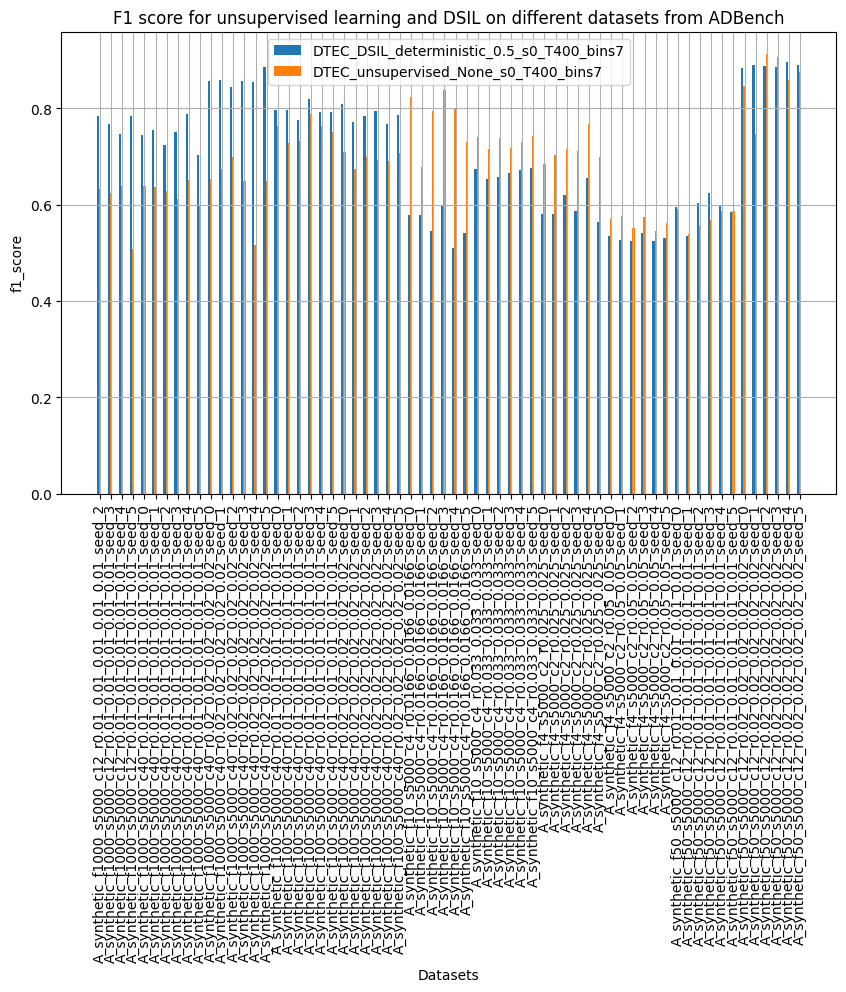

In [28]:

datasets = mean_df["dataset_name"].unique()
experiments = mean_df["experiment"].unique()
bar_width = 0.2
num_datasets = len(datasets)
num_experiments = len(experiments)
r = np.arange(num_datasets)
_, ax = plt.subplots(figsize=(10, 6))
for i, experiment in enumerate(experiments):
    mean_experiment = mean_df[mean_df["experiment"] == experiment]
    mean_experiment = mean_experiment.sort_values(by="dataset_name")[
        "f1_score"
    ].values

    ax.bar(
        r + i * bar_width,
        mean_experiment,
        width=bar_width,
        label=experiment,
    )
ax.set_xlabel("Datasets")
ax.set_ylabel("f1_score")
ax.set_title("F1 score for unsupervised learning and DSIL on different datasets from ADBench")
ax.set_xticks(r + bar_width * (num_experiments) / 2)
ax.set_xticklabels(datasets)

ax.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

In [19]:
unsup_bin_mean_df = mean_df[mean_df['training_method'] == METHOD]
unsup_bin_mean_df = unsup_bin_mean_df[unsup_bin_mean_df['T'] == 400]
unsup_bin_std_df = std_df[std_df['training_method'] == METHOD]
unsup_bin_std_df = unsup_bin_std_df[unsup_bin_std_df['T'] == 400]

NameError: name 'std_df' is not defined

In [32]:
unsup_bin_mean_df.head()

,experiment,dataset_name,training_method,training_time,inference_time,f1_score,random_seed,aucroc,nb_bins,T,anomaly_ratio
38,DTEC_unsupervised_None_s0_T400_bins7,10_cover,unsupervised,5052.710342,1.700469,0.023707,0.0,0.717308,7.0,400.0,0.0
39,DTEC_unsupervised_None_s0_T400_bins7,11_donors,unsupervised,4733.827002,2.480758,0.156809,0.0,0.776798,7.0,400.0,0.0
40,DTEC_unsupervised_None_s0_T400_bins7,12_fault,unsupervised,205.197592,0.136313,0.451709,0.0,0.609995,7.0,400.0,0.0
41,DTEC_unsupervised_None_s0_T400_bins7,13_fraud,unsupervised,5157.683881,2.337312,0.782609,0.0,0.959149,7.0,400.0,0.0
42,DTEC_unsupervised_None_s0_T400_bins7,14_glass,unsupervised,100.079457,0.035327,0.160000,0.0,0.848316,7.0,400.0,0.0


In [33]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(unsup_bin_mean_df, unsup_bin_std_df, on=["experiment", "dataset_name", "T", "nb_bins"], suffixes=('_mean', '_std'))

# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["f1_score_str"] = merged_df.apply(
    lambda row: f"{row['f1_score_mean']:.2f}({row['f1_score_std']:.2f})", axis=1
)
merged_df['aucroc_str'] = merged_df.apply(
    lambda row: f"{row['aucroc_mean']:.2f}({row['aucroc_std']:.2f})", axis=1
)


NameError: name 'unsup_bin_std_df' is not defined

In [ ]:
merged_df.head()

,experiment,dataset_name,training_method_mean,T,nb_bins,training_time_mean,inference_time_mean,f1_score_mean,random_seed_mean,aucroc_mean,anomaly_ratio_mean,training_method_std,training_time_std,inference_time_std,f1_score_std,random_seed_std,aucroc_std,anomaly_ratio_std,f1_score_str,aucroc_str
0,DTEC_unsupervised_None_s0_T400_bins16,10_cover,unsupervised,400,16,5094.611974,1.553268,0.021552,0.0,0.778820,0.0,unsupervised,NaN,NaN,NaN,NaN,NaN,NaN,0.02(nan),0.78(nan)
1,DTEC_unsupervised_None_s0_T400_bins16,11_donors,unsupervised,400,16,4774.178772,1.889866,0.036795,0.0,0.839968,0.0,unsupervised,NaN,NaN,NaN,NaN,NaN,NaN,0.04(nan),0.84(nan)
2,DTEC_unsupervised_None_s0_T400_bins16,12_fault,unsupervised,400,16,209.570229,0.083300,0.411590,0.0,0.557660,0.0,unsupervised,NaN,NaN,NaN,NaN,NaN,NaN,0.41(nan),0.56(nan)
3,DTEC_unsupervised_None_s0_T400_bins16,13_fraud,unsupervised,400,16,5276.103636,2.299125,0.456522,0.0,0.960134,0.0,unsupervised,NaN,NaN,NaN,NaN,NaN,NaN,0.46(nan),0.96(nan)
4,DTEC_unsupervised_None_s0_T400_bins16,14_glass,unsupervised,400,16,97.174903,0.030919,0.160000,0.0,0.788758,0.0,unsupervised,NaN,NaN,NaN,NaN,NaN,NaN,0.16(nan),0.79(nan)


In [ ]:
# Keep in another df f1_score_str, datasetname, nb_bins and experiment
tmp = merged_df[['f1_score_str', 'dataset_name', 'nb_bins']]
# Handle duplicates by aggregating (keeping the first entry for each duplicate combination)
df_cleaned = tmp.groupby(["dataset_name", "nb_bins"], as_index=False).agg({"f1_score_str": "first"})

# Pivot the cleaned DataFrame
df_pivot = df_cleaned.pivot(index="dataset_name", columns="nb_bins", values="f1_score_str").reset_index()

# Rename columns for clarity
df_pivot.columns.name = None  # Remove the multi-index
df_pivot.columns = ["dataset_name"] + [f"nb_bins {col}" for col in df_pivot.columns[1:]]

In [ ]:

latex_str = dataframe_to_latex(df_pivot, caption=f"F1 score for {METHOD} with different value of nb_bins", label=f"tab:{METHOD}_f1_score", index=False)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_str)

# Optional: Print the LaTeX table for verification
print(latex_str.replace("\n", " "))

\begin{table}[ht] \centering \caption{F1 score for unsupervised with different value of nb_bins} \label{tab:unsupervised_f1_score} \begin{tabular}{llll} \toprule dataset name & nb bins 7 & nb bins 16 & nb bins 32 \\ \midrule 10 cover & 0.02(nan) & 0.02(nan) & 0.03(nan) \\ 11 donors & 0.16(nan) & 0.04(nan) & 0.04(nan) \\ 12 fault & 0.45(nan) & 0.41(nan) & 0.36(nan) \\ 13 fraud & 0.78(nan) & 0.46(nan) & 0.41(nan) \\ 14 glass & 0.16(nan) & 0.16(nan) & 0.16(nan) \\ 15 Hepatitis & 0.36(nan) & 0.38(nan) & 0.42(nan) \\ 16 http & 0.01(nan) & 0.01(nan) & 0.01(nan) \\ 18 Ionosphere & 0.77(nan) & 0.70(nan) & 0.70(nan) \\ 19 landsat & 0.20(nan) & 0.19(nan) & 0.19(nan) \\ 21 Lymphography & 0.73(nan) & 0.73(nan) & 0.43(nan) \\ 23 mammography & 0.20(nan) & 0.22(nan) & 0.29(nan) \\ 25 musk & 0.23(nan) & 0.21(nan) & 0.00(nan) \\ 27 PageBlocks & 0.56(nan) & 0.60(nan) & 0.58(nan) \\ 29 Pima & 0.48(nan) & 0.47(nan) & 0.49(nan) \\ 2 annthyroid & 0.62(nan) & 0.64(nan) & 0.60(nan) \\ 30 satellite & 0.61(nan)

/home/elouan/code/code_repo/notebooks/utils_notebook.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace("_", " "))


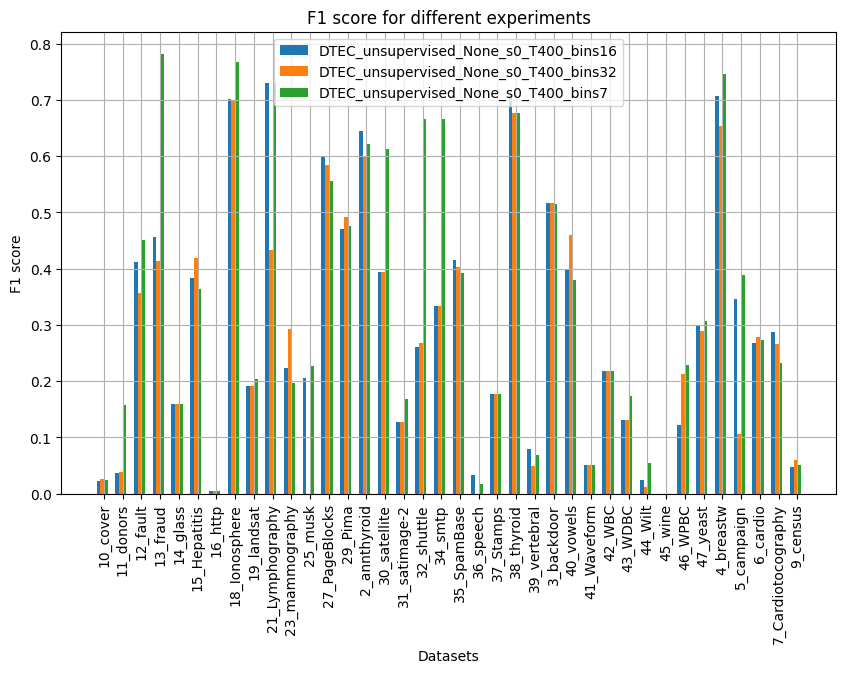

In [ ]:
histogram_experiment(mean_df=unsup_bin_mean_df, std_df=unsup_bin_std_df, column="f1_score", ylabel="F1 score", title="F1 score for different experiments", synthetic=False)

In [ ]:
# Keep in another df f1_score_str, datasetname, nb_bins and experiment
tmp = merged_df[['aucroc_str', 'dataset_name', 'nb_bins']]
# Handle duplicates by aggregating (keeping the first entry for each duplicate combination)
df_cleaned = tmp.groupby(["dataset_name", "nb_bins"], as_index=False).agg({"aucroc_str": "first"})

# Pivot the cleaned DataFrame
df_pivot = df_cleaned.pivot(index="dataset_name", columns="nb_bins", values="aucroc_str").reset_index()

# Rename columns for clarity
df_pivot.columns.name = None  # Remove the multi-index
df_pivot.columns = ["dataset_name"] + [f"nb_bins {col}" for col in df_pivot.columns[1:]]

In [ ]:

latex_str = dataframe_to_latex(df_pivot, caption=f"AUCROC for {METHOD} with different value of nb_bins", label="tab:bin_aucroc", index=False)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_str)

# Optional: Print the LaTeX table for verification
print(latex_str.replace("\n", " "))

\begin{table}[ht] \centering \caption{AUCROC for unsupervised with different value of nb_bins} \label{tab:bin_aucroc} \begin{tabular}{llll} \toprule dataset name & nb bins 7 & nb bins 16 & nb bins 32 \\ \midrule 10 cover & 0.72(nan) & 0.78(nan) & 0.90(nan) \\ 11 donors & 0.78(nan) & 0.84(nan) & 0.82(nan) \\ 12 fault & 0.61(nan) & 0.56(nan) & 0.52(nan) \\ 13 fraud & 0.96(nan) & 0.96(nan) & 0.95(nan) \\ 14 glass & 0.85(nan) & 0.79(nan) & 0.79(nan) \\ 15 Hepatitis & 0.73(nan) & 0.70(nan) & 0.79(nan) \\ 16 http & 0.99(nan) & 0.99(nan) & 0.99(nan) \\ 18 Ionosphere & 0.93(nan) & 0.91(nan) & 0.90(nan) \\ 19 landsat & 0.54(nan) & 0.49(nan) & 0.47(nan) \\ 21 Lymphography & 0.98(nan) & 0.99(nan) & 0.92(nan) \\ 23 mammography & 0.78(nan) & 0.83(nan) & 0.84(nan) \\ 25 musk & 0.96(nan) & 0.95(nan) & 0.50(nan) \\ 27 PageBlocks & 0.92(nan) & 0.92(nan) & 0.91(nan) \\ 29 Pima & 0.62(nan) & 0.60(nan) & 0.62(nan) \\ 2 annthyroid & 0.95(nan) & 0.98(nan) & 0.97(nan) \\ 30 satellite & 0.73(nan) & 0.62(nan) 

/home/elouan/code/code_repo/notebooks/utils_notebook.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace("_", " "))


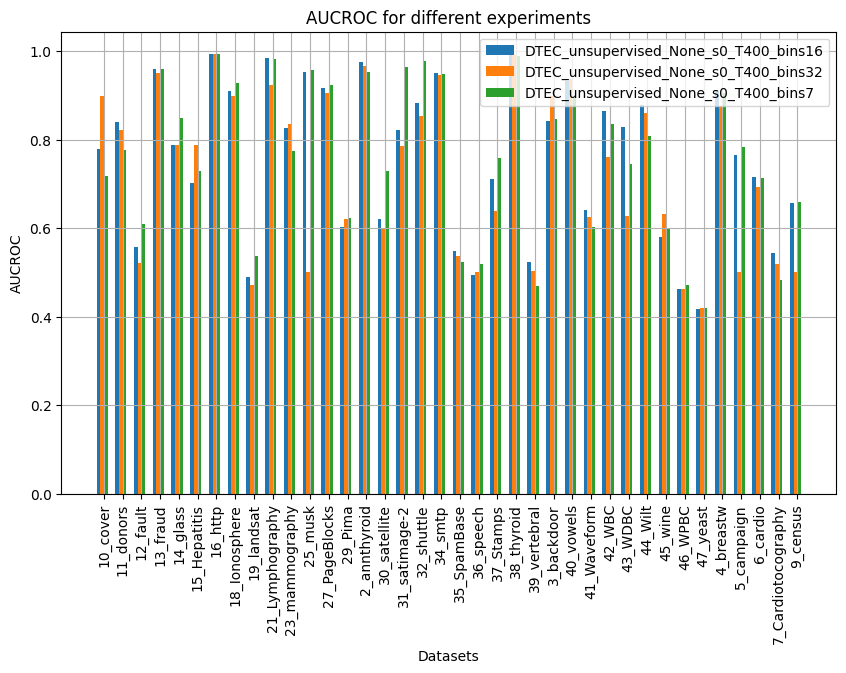

In [ ]:
histogram_experiment(mean_df=unsup_bin_mean_df, std_df=unsup_bin_std_df, column="aucroc", ylabel="AUCROC", title="AUCROC for different experiments", synthetic=False)

# T


In [ ]:
unsup_T_mean_df = mean_df[mean_df['training_method'] == METHOD]
unsup_T_mean_df = unsup_T_mean_df[unsup_T_mean_df['nb_bins'] == 16]
unsup_T_std_df = std_df[std_df['training_method'] == METHOD]
unsup_T_std_df = unsup_T_std_df[unsup_T_std_df['nb_bins'] == 16]


In [ ]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(unsup_T_mean_df, unsup_T_std_df, on=["experiment", "dataset_name", "T", "nb_bins"], suffixes=('_mean', '_std'))

# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["f1_score_str"] = merged_df.apply(
    lambda row: f"{row['f1_score_mean']:.2f}({row['f1_score_std']:.2f})", axis=1
)
merged_df['aucroc_str'] = merged_df.apply(
    lambda row: f"{row['aucroc_mean']:.2f}({row['aucroc_std']:.2f})", axis=1
)


In [ ]:
# Keep in another df f1_score_str, datasetname, nb_bins and experiment
tmp = merged_df[['f1_score_str', 'dataset_name', 'T']]
# Handle duplicates by aggregating (keeping the first entry for each duplicate combination)
df_cleaned = tmp.groupby(["dataset_name", "T"], as_index=False).agg({"f1_score_str": "first"})

# Pivot the cleaned DataFrame
df_pivot = df_cleaned.pivot(index="dataset_name", columns="T", values="f1_score_str").reset_index()

# Rename columns for clarity
df_pivot.columns.name = None  # Remove the multi-index
df_pivot.columns = ["dataset_name"] + [f"T {col}" for col in df_pivot.columns[1:]]

latex_str = dataframe_to_latex(df_pivot, caption=f"F1 score for {METHOD} with different value of T", label="tab:T_f1", index=False)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_str)

# Optional: Print the LaTeX table for verification
print(latex_str.replace("\n", " "))

\begin{table}[ht] \centering \caption{F1 score for unsupervised with different value of T} \label{tab:T_f1} \begin{tabular}{llll} \toprule dataset name & T 100 & T 200 & T 400 \\ \midrule 10 cover & 0.05(nan) & 0.04(nan) & 0.02(nan) \\ 11 donors & 0.05(nan) & 0.05(nan) & 0.04(nan) \\ 12 fault & 0.33(nan) & 0.39(nan) & 0.41(nan) \\ 13 fraud & 0.47(nan) & 0.47(nan) & 0.46(nan) \\ 14 glass & 0.16(nan) & 0.10(nan) & 0.16(nan) \\ 15 Hepatitis & 0.07(nan) & 0.28(nan) & 0.38(nan) \\ 16 http & 0.00(nan) & 0.04(nan) & 0.01(nan) \\ 18 Ionosphere & 0.72(nan) & 0.75(nan) & 0.70(nan) \\ 19 landsat & 0.17(nan) & 0.19(nan) & 0.19(nan) \\ 21 Lymphography & 0.16(nan) & 0.24(nan) & 0.73(nan) \\ 23 mammography & 0.25(nan) & 0.23(nan) & 0.22(nan) \\ 25 musk & 0.01(nan) & 0.16(nan) & 0.21(nan) \\ 27 PageBlocks & 0.61(nan) & 0.60(nan) & 0.60(nan) \\ 29 Pima & 0.31(nan) & 0.44(nan) & 0.47(nan) \\ 2 annthyroid & 0.69(nan) & 0.68(nan) & 0.64(nan) \\ 30 satellite & 0.53(nan) & 0.37(nan) & 0.39(nan) \\ 31 satima

/home/elouan/code/code_repo/notebooks/utils_notebook.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace("_", " "))


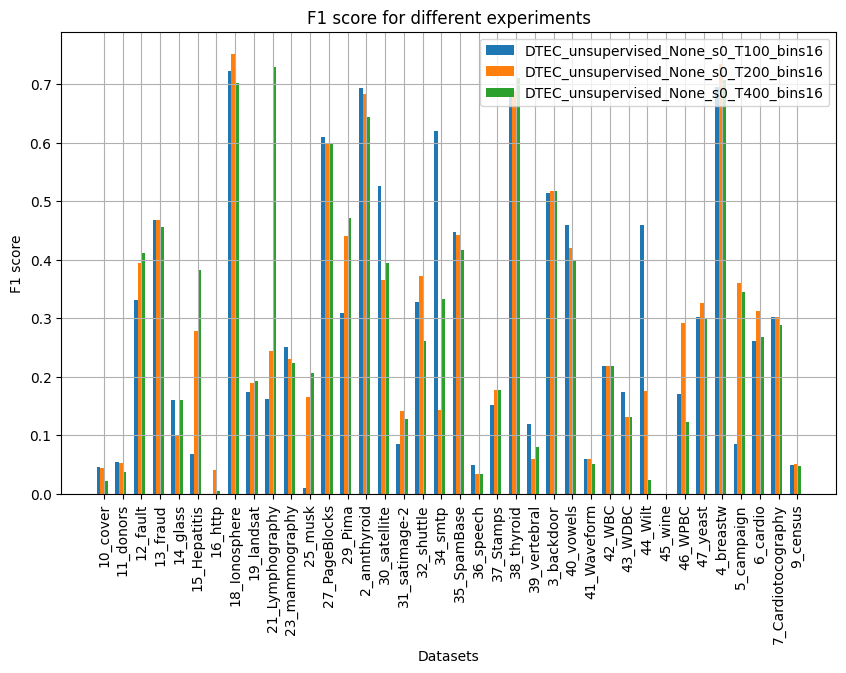

In [ ]:
histogram_experiment(mean_df=unsup_T_mean_df, std_df=unsup_T_std_df, column="f1_score", ylabel="F1 score", title="F1 score for different experiments", synthetic=False)

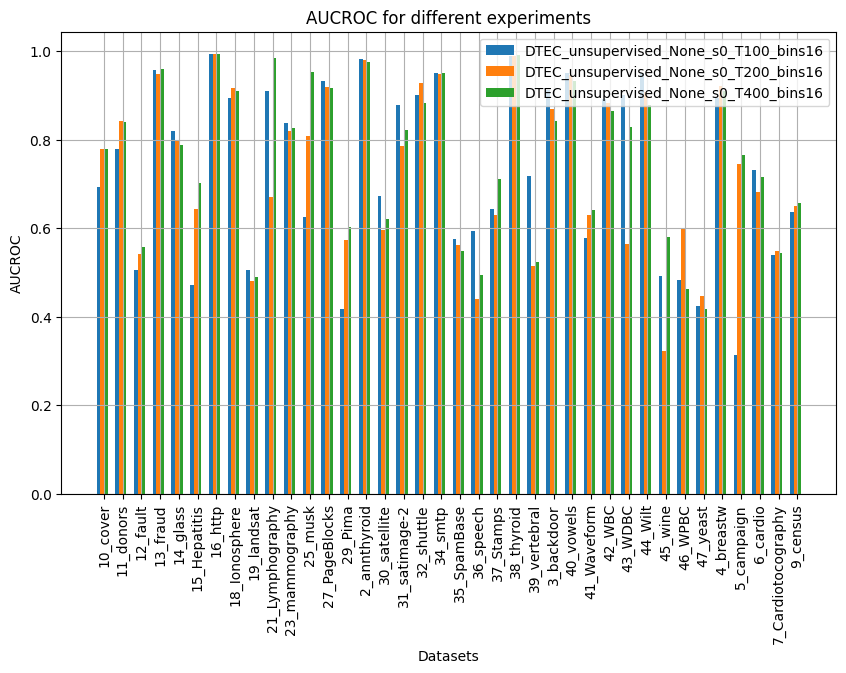

In [ ]:
histogram_experiment(mean_df=unsup_T_mean_df, std_df=unsup_T_std_df, column="aucroc", ylabel="AUCROC", title="AUCROC for different experiments", synthetic=False)

In [ ]:
# Sort datasets by dimension
mean_df = mean_df.sort_values('dimension')
std_df = std_df.sort_values('dimension')
datasets = mean_df['dataset_name'].unique()

# Extract unique methods
methods = ["local_explanation_time", "shap_explanation_time",]# "grad_explanation_time"]
num_datasets = len(datasets)
num_methods = len(methods)

r = np.arange(num_datasets)
bar_width = 0.3  # Adjust bar width to fit the methods

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each method's average explanation time as a bar
for i, method in enumerate(methods):
    method_mean = mean_df.groupby("dataset_name")[method].mean().reindex(datasets)
    method_std = std_df.groupby("dataset_name")[method].std().reindex(datasets)
    ax.bar(r + i * bar_width, method_mean.values, width=bar_width, yerr=method_std.values, label=method)

# Add labels, title, and customize the x-axis
ax.set_xlabel('Datasets (Ordered by Dimension)')
ax.set_ylabel('Explanation Time (seconds)')
ax.set_title('Explanation Time for Different Datasets and Methods')
ax.set_xticks(r -1 + bar_width * (num_methods - 1) / 2)
ax.set_xticklabels(datasets)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.yscale('log')
# Show the plot
plt.tight_layout()
plt.show()


KeyError: 'dimension'

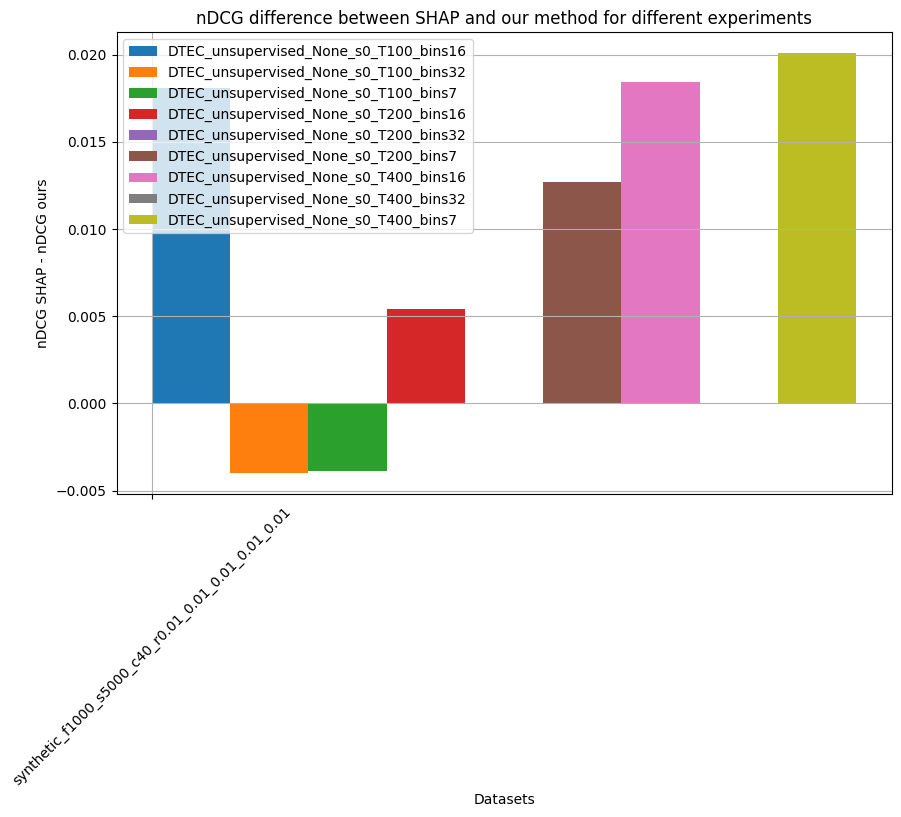

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="ndcg_diff_shap_ours", ylabel="nDCG SHAP - nDCG ours", title="nDCG difference between SHAP and our method for different experiments")

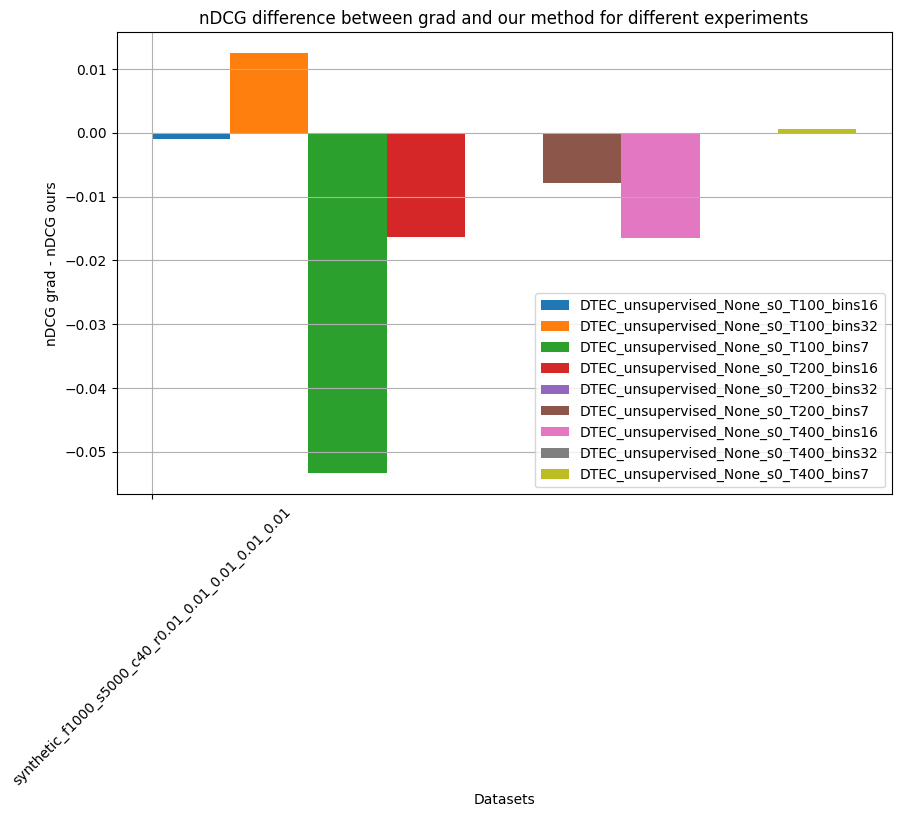

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="ndcg_diff_grad_ours", ylabel="nDCG grad - nDCG ours", title="nDCG difference between grad and our method for different experiments")

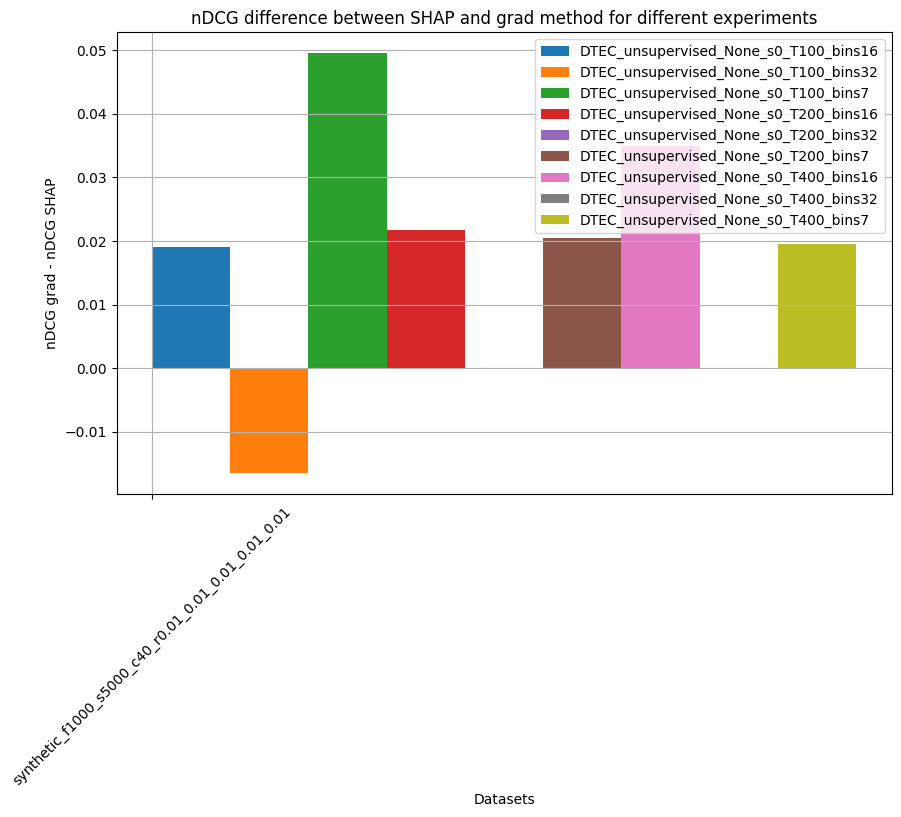

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="ndcg_diff_shap_grad", ylabel="nDCG grad - nDCG SHAP", title="nDCG difference between SHAP and grad method for different experiments")

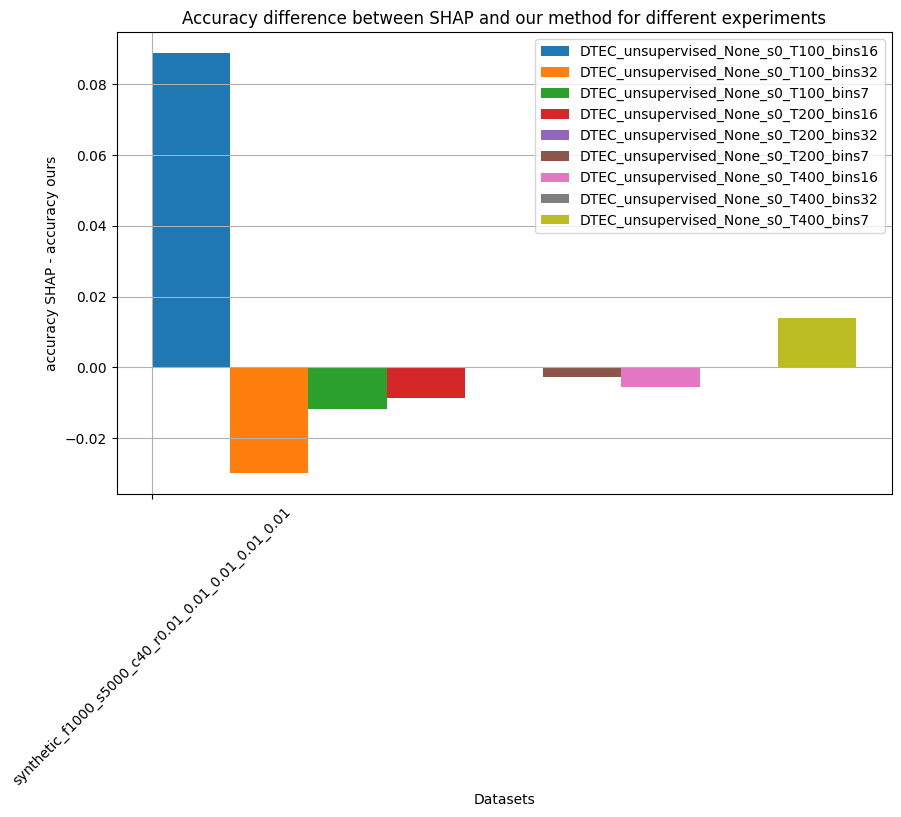

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="accuracy_diff_shap_ours", ylabel="accuracy SHAP - accuracy ours", title="Accuracy difference between SHAP and our method for different experiments")

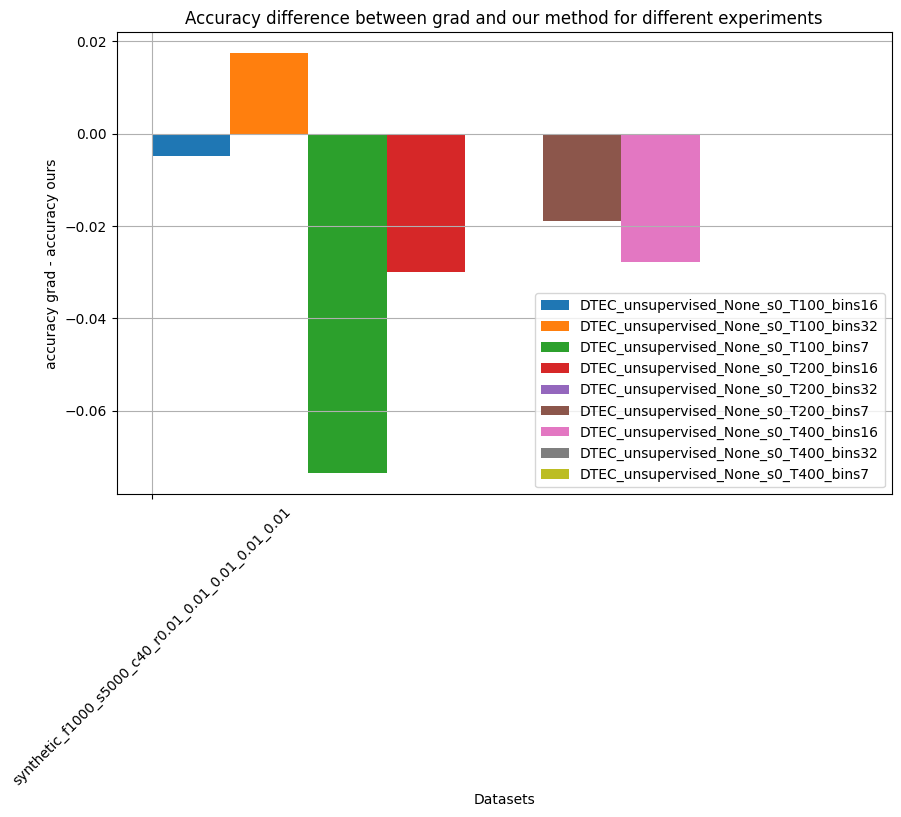

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="accuracy_diff_grad_ours", ylabel="accuracy grad - accuracy ours", title="Accuracy difference between grad and our method for different experiments")

In [ ]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(mean_df, std_df, on=["dataset_name", "experiment", "dimension", "anomaly_ratio"], suffixes=('_mean', '_std'))
# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["f1_score_str"] = merged_df.apply(
    lambda row: f"${row['f1_score_mean']:.2f}({row['f1_score_std']:.2f})$", axis=1
)

# Step 3: Drop the separate mean and std columns if needed
merged_df = merged_df.drop(columns=["f1_score_mean", "f1_score_std"])
print(merged_df.columns)
latex_table = dataframe_to_latex(
    merged_df[['experiment', 'dataset_name', "anomaly_ratio",'f1_score_str']],
    column_format="llc",  
    caption="Mean and Standard Deviation of F1 score for Different Experiments and Datasets",
    label="tab:mean_std",
    index=False
)
with open("latex_table.tex", "w") as f:
    f.write(latex_table)
latex_table.replace("\n", " ")

Index(['experiment', 'dataset_name', 'training_time_mean',
       'inference_time_mean', 'random_seed_mean', 'aucroc_mean',
       'grad_explanation_accuracy_mean', 'shap_explanation_accuracy_mean',
       'feature_importance_accuracy_mean', 'grad_feature_importance_ndcg_mean',
       'grad_explanation_time_mean', 'feature_importance_ndcg_mean',
       'shap_feature_importance_ndcg_mean', 'global_explanation_time_mean',
       'local_explanation_time_mean', 'shap_explanation_time_mean',
       'dimension', 'anomaly_ratio', 'ndcg_diff_shap_ours_mean',
       'ndcg_diff_grad_ours_mean', 'accuracy_diff_shap_ours_mean',
       'accuracy_diff_grad_ours_mean', 'ndcg_diff_shap_grad_mean',
       'accuracy_diff_shap_grad_mean', 'training_time_std',
       'inference_time_std', 'random_seed_std', 'aucroc_std',
       'grad_explanation_accuracy_std', 'shap_explanation_accuracy_std',
       'feature_importance_accuracy_std', 'grad_feature_importance_ndcg_std',
       'grad_explanation_time_std', 

/home/elouan/code/code_repo/notebooks/utils_notebook.py:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace("_", " "))


'\\begin{table}[ht] \\centering \\caption{Mean and Standard Deviation of F1 score for Different Experiments and Datasets} \\label{tab:mean_std} \\begin{tabular}{llc} \\toprule experiment & dataset name & anomaly ratio & f1 score str \\\\ \\midrule \\bottomrule \\end{tabular} \\end{table}'

In [ ]:
# Define a function to extract and sum all ratios from the dataset name
def extract_ratios(dataset_name):
    # Use re.findall to capture all numerical ratios
    ratios = re.findall(r'r([0-9]*\.?[0-9]+)|_([0-9]*\.?[0-9]+)', dataset_name)
    # Flatten the list of tuples and filter out empty strings
    ratios = [float(r) for pair in ratios for r in pair if r]
    # Return the sum of the ratios
    return f"{sum(ratios) * 100:.2f}"
def rename_row(dataset_name):
    return "synthetic {} - {}".format(re.search(r"f(\d+)", dataset_name).group(1), extract_ratios(dataset_name))
# In dataset name, keep only the word "synthetic" and the number of feature which is after "f_"ArithmeticError
merged_df['dataset_name'] = merged_df['dataset_name'].apply(rename_row)


# Step 4: Pivot the DataFrame to have experiments as columns and datasets as rows
pivot_df = merged_df.pivot(index="dataset_name", columns="experiment", values="f1_score_str")

# If there is NaN in a column, remove the column
pivot_df = pivot_df.replace("nan", np.nan)
pivot_df = pivot_df.dropna(axis=1)
# Same if its nan in a string "nan"
# Step 5: Convert the pivoted DataFrame to LaTeX
latex_table = dataframe_to_latex(
    pivot_df,
    column_format="l" + "c" * (pivot_df.shape[1]),  # Adjust column format dynamically
    caption="F1 Score with Mean and Standard Deviation for Different Experiments and Datasets",
    label="tab:mean_std",
    index=True  # Include the row index (datasets)
)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_table)

# Optional: Print the LaTeX table for verification
print(latex_table.replace("\n", " "))

\begin{table}[ht] \centering \caption{F1 Score with Mean and Standard Deviation for Different Experiments and Datasets} \label{tab:mean_std} \begin{tabular}{l} \toprule dataset_name \\ \midrule \bottomrule \end{tabular} \end{table}


/home/elouan/code/code_repo/notebooks/utils_notebook.py:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace("_", " "))


In [ ]:
# Turn nDCG and accuracy to string
merged_df["shape_nDCG_str"] = merged_df.apply(
    lambda row: f"${row['shap_feature_importance_ndcg_mean']:.2f}({row['shap_feature_importance_ndcg_std']:.2f})$", axis=1)
merged_df["shape_accuracy_str"] = merged_df.apply(
    lambda row: f"${row['shap_explanation_accuracy_mean']:.2f}({row['shap_explanation_accuracy_std']:.2f})$", axis=1
)
merged_df['local_nDCG_srt'] = merged_df.apply(
    lambda row: f"${row['feature_importance_ndcg_mean']:.2f}({row['feature_importance_ndcg_std']:.2f})$", axis=1
)
merged_df['local_accuracy_str'] = merged_df.apply(
    lambda row: f"${row['feature_importance_accuracy_mean']:.2f}({row['feature_importance_accuracy_std']:.2f})$", axis=1
)
merged_df['grad_nDCG_str'] = merged_df.apply(
    lambda row: f"${row['grad_feature_importance_ndcg_mean']:.2f}({row['grad_feature_importance_ndcg_std']:.2f})$", axis=1
)
merged_df['grad_accuracy_str'] = merged_df.apply(
    lambda row: f"${row['grad_explanation_accuracy_mean']:.2f}({row['grad_explanation_accuracy_std']:.2f})$", axis=1
)

In [ ]:
# Step 4: Pivot the DataFrame to have experiments as columns and datasets as rows
pivot_df = merged_df.pivot(index="dataset_name", columns="experiment", values=["shape_nDCG_str", "shape_accuracy_str", "local_nDCG_srt", "local_accuracy_str", "grad_nDCG_str", "grad_accuracy_str"])

# If there is NaN in a column, remove the column
pivot_df = pivot_df.replace("nan", np.nan)
pivot_df = pivot_df.dropna(axis=1)
pivot_df

dataset_name


In [ ]:
# Same if its nan in a string "nan"
# Step 5: Convert the pivoted DataFrame to LaTeX
latex_table = dataframe_to_latex(
    pivot_df,
    column_format="l" + "c" * (pivot_df.shape[1]),  # Adjust column format dynamically
    caption="F1 Score with Mean and Standard Deviation for Different Experiments and Datasets",
    label="tab:mean_std",
    index=True  # Include the row index (datasets)
)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_table)

# Optional: Print the LaTeX table for verification
print(latex_table.replace("\n", " "))

AttributeError: Can only use .str accessor with Index, not MultiIndex

In [ ]:
merged_df.columns

In [ ]:
dataframe_to_latex(
    merged_df[['experiment', 'dataset_name', 'shap_feature_importance_ndcg_m', 'grad_feature_importance_ndcg', 'feature_importance_ndcg', "shap_explanation_accuracy_mean", "grad_explanation_accuracy_mean", "local_explanation_accuracy_mean"]],
    column_format="llccc",  
    caption="NDCG for Different Experiments and Datasets",
    label="tab:ndcg",
    index=False
)

In [ ]:
baseline_comp_dataset = pd.DataFrame()
temp_df = full_results_df
temp_df['dataset_name'] = temp_df['dataset_name'] + "_" + temp_df['dataset_version']
for dataset_name in full_results_df["dataset_name"].unique():
    dataset_results = full_results_df[full_results_df["dataset_name"] == dataset_name]
    baseline_results = dataset_results[dataset_results["training_method"] == "unsupervised"]
    dataset_results['f1_score_diff'] = dataset_results['f1_score'] - baseline_results['f1_score'].values[0]
    dataset_results['aucroc_diff'] = dataset_results['aucroc'] - baseline_results['aucroc'].values[0]
    dataset_results['aucroc_ratio'] = dataset_results['aucroc'] / baseline_results['aucroc'].values[0]
    dataset_results['f1_score_ratio'] = dataset_results['f1_score'] / baseline_results['f1_score'].values[0]
    dataset_results['feature_importance_ndcg_diff'] = dataset_results['feature_importance_ndcg'] - baseline_results['feature_importance_ndcg'].values[0]
    dataset_results['shap_feature_importance_ndcg_diff'] = dataset_results['shap_feature_importance_ndcg'] - baseline_results['shap_feature_importance_ndcg'].values[0]
    baseline_comp_dataset = pd.concat([baseline_comp_dataset, dataset_results]) 